<a href="https://colab.research.google.com/github/Kushagratandon12/Diabetic_retinopathy/blob/main/Diabetic_Retinopathy_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
!pip install -q -U keras-tuner
!rm -rf /content/sample_data
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 71kB 7.8MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading The Dataset

In [3]:
%%capture
# !kaggle datasets download -d kushagratandon12/diabetic-retinopathy-processed-data
!unzip /content/drive/MyDrive/Diabetic_Balanced_Data.zip
!rm -rf /content/diabetic-retinopathy-processed-data.zip

In [4]:
import os 
import gc
import cv2
import glob
import random
import numpy as np
import pandas as pd
from os import path
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [5]:
def show_data(path_dataset):
  images_data = glob.glob(path_dataset)
  random.shuffle(images_data)
  plt.figure(figsize=(10,10))
  for i in range(9):
    plt.subplot(3,3,i+1)
    img = plt.imread(images_data[i-1])
    plt.imshow(img)

def plot_data(dataset):
  print('Total Number Of Images {}'.format(len(dataset)))
  img_files = [os.path.basename(name) for name in dataset]
  data_label = [str(name.split('/')[-2]) for name in dataset]
  df = pd.DataFrame({'filename':img_files,'label':data_label})
  sns.countplot(df['label'])
  df['label'].value_counts()
  return df

In [ ]:
# dataset = glob.glob('/content/content/processed_data/*/*.jpeg')
# df = plot_data(dataset)

In [6]:
classes=['No_Dr','Mild','Moderate','severe','Proliferative DR']
class_dict = {}
for i,label in enumerate(classes):
  class_dict[i]=label
print(class_dict)

# label_1 = glob.glob('/content/processed_data/4/*.jpeg')
# label_1 = list(label_1[10000::])
# print(len(label_1))
# for i in range(len(label_1)):
#   os.remove(label_1[i])

{0: 'No_Dr', 1: 'Mild', 2: 'Moderate', 3: 'severe', 4: 'Proliferative DR'}


Plot Images In A Directory -> Function

## Image Aug using IMAGAUG 

In [ ]:
dataset = glob.glob('/content/processed_data/*/*.jpeg')
print('Total Number Of Images {}'.format(len(dataset)))
img_files = [os.path.basename(name) for name in dataset]
data_label = [int(name.split('/')[-2]) for name in dataset]

df = pd.DataFrame({'filename':img_files,'label':data_label})

Total Number Of Images 42061


In [ ]:
df_minor = df.loc[(df['label'] !=0) & (df['label'] !=2) & (df['label'] !=1) ]
# df_minor.head()

minor_imgs =[]
for iter,row in df_minor.iterrows():
    fname = os.path.join(os.path.join('/content/processed_data',str(row.label)),
                         row.filename)
    minor_imgs.append(fname)
print(len(minor_imgs))
gc.collect()

diabetic_imgs= minor_imgs
diabetic_imgs = np.asarray(diabetic_imgs)
np.random.shuffle(diabetic_imgs)
print(diabetic_imgs.shape)


from google.colab.patches import cv2_imshow
plt.figure(figsize=(10, 10))


def decode_img(filename,shape=(512,512)):
    img = image.load_img(filename,target_size=(shape))
    img  = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    print(img.shape)
    return img

data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomRotation((0.1,0.3),fill_mode='nearest'),
      layers.experimental.preprocessing.RandomZoom(0.2),
      layers.experimental.preprocessing.RandomContrast(0.2)])


12358
(12358,)


<Figure size 720x720 with 0 Axes>

In [ ]:
import imageio
import warnings
from imgaug import augmenters as iaa
from google.colab.patches import cv2_imshow
warnings.filterwarnings('ignore')

plt.figure(figsize=(10, 10))

seq = iaa.Sequential([
    		iaa.Crop(px=(0, 16)),
    		iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-25,25)),
            iaa.LinearContrast(alpha=1.2),
            iaa.GaussianBlur(sigma=1.5)
    		])

def read_img(filename,shape=(512,512)):
    img = image.load_img(filename,target_size=(shape))
    img  = image.img_to_array(img)
    return img

def load_batch(img_list,batch=32,count=0):
    imgs = [] 
    fnames  = []
    i = count*batch
    for filename in img_list[i:batch*(count+1)]:
        img = read_img(filename)
        imgs.append(img)
        fnames.append(filename)
    return imgs,fnames

nb_batches  =  len(diabetic_imgs)//32
# print(nb_batches)

for idx in tqdm(range(nb_batches),position=0):
    images,fnames = load_batch(diabetic_imgs,count=idx)
    images_aug = seq(images=images)
    for im, im_aug in enumerate(images_aug):
        name = fnames[im][:-4]+'_aug_'+str(im)+'.jpeg'
        imageio.imwrite(name, im_aug)

gc.collect()
    

***Spliting Dataset***

In [ ]:
input_data = '/content/processed_data'
output_data = '/content/Diabetic_Balanced_Data'
! mkdir /content/Diabetic_Balanced_Data
if len(os.listdir(output_data))==0:
  splitfolders.ratio(input_data, output=output_data,seed=100, ratio=(.7, .2, .1), group_prefix=None)

mkdir: cannot create directory ‘/content/Diabetic_Balanced_Data’: File exists


Copying files: 49703 files [00:29, 1707.41 files/s]


In [ ]:
# !zip -r /content/Diabetic_Balanced_Data.zip /content/
!mv /content/Diabetic_Balanced_Data.zip /content/drive/MyDrive/

#Model Creation


In [10]:
#Hyper-Parameter Declarations 
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_SHAPE=(IMG_WIDTH,IMG_HEIGHT)
test_data = '/content/content/Diabetic_Balanced_Data/test'
training_data = '/content/content/Diabetic_Balanced_Data/train'
validation_data = '/content/content/Diabetic_Balanced_Data/val'

In [9]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
  rescale = 1.0/255.0,
  )

training_datagen = image_data_generator.flow_from_directory(
    training_data,
    target_size=IMG_SHAPE,
    shuffle=True,
)

validation_datagen = image_data_generator.flow_from_directory(
    validation_data,
    target_size=IMG_SHAPE,
    shuffle = True
)

test_datagen = image_data_generator.flow_from_directory(
    test_data,
    target_size=IMG_SHAPE,
    shuffle=True)

Found 34792 images belonging to 5 classes.
Found 9940 images belonging to 5 classes.
Found 4971 images belonging to 5 classes.


# KERAS HYPERTUNER


In [ ]:
# !rm -rf /content/drive/MyDrive/Diabetic_Hypertuner

In [ ]:
import kerastuner as kt
import tensorflow
from tensorflow import keras
def model_builder(hp):
  model_type = hp.Choice('model_type',['ResNet50V2'])

  if model_type == 'ResNet50V2':
    base_model = ResNet50V2(input_shape=(IMG_WIDTH,IMG_HEIGHT,3),include_top=False,weights='imagenet')
    head_model = base_model
    for layers in base_model.layers[:45]:
      layers.trainable=True
    head_model = head_model.output
    head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
    head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
    hp_units = hp.Int('units', min_value=1300, max_value=1750, step=150)
    head_model = tf.keras.layers.Dense(hp_units,activation='relu')(head_model)
    head_model = tf.keras.layers.Dropout(0.3)(head_model)
    prediction_layer = tf.keras.layers.Dense(len(classes), activation='relu')(head_model)
    model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.categorical_crossentropy,
                metrics=['accuracy'])

  return model


tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=5,
                     directory='/content/drive/MyDrive/Diabetic_Hypertuner',
                     project_name='diabetic_parameters')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training_datagen, 
             epochs=5, 
             verbose=1,
             shuffle=True,
             validation_data=validation_datagen, 
             callbacks=[stop_early]
             )

Trial 3 Complete [01h 15m 20s]
val_accuracy: 0.40231388807296753

Best val_accuracy So Far: 0.5737424492835999
Total elapsed time: 03h 17m 02s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
model_type        |ResNet50V2        |ResNet50V2        
units             |1300              |1600              
learning_rate     |0.0001            |0.0001            
tuner/epochs      |10                |10                
tuner/initial_e...|0                 |2                 
tuner/bracket     |0                 |1                 
tuner/round       |0                 |1                 

Epoch 1/10
1088/1088 [==============================] - 460s 418ms/step - loss: 1.5651 - accuracy: 0.3877 - val_loss: 1.3126 - val_accuracy: 0.3795
Epoch 2/10
1088/1088 [==============================] - 454s 417ms/step - loss: 1.3043 - accuracy: 0.4423 - val_loss: 1.1056 - val_accuracy: 0.5379
Epoch 3/10
1088/1088 [==============================] - 454s 417ms/step - los

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps)
model = tuner.hypermodel.build(best_hps)
history = model.fit(training_datagen, epochs=20,validation_data=validation_datagen)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# Model 

In [11]:
%load_ext tensorboard
from datetime import datetime
import os

In [17]:
def define_model(n_layers=45,BASE_MODEL='ResNet50V2'):
    if BASE_MODEL =='ResNet50V2':
        # Pre-trained model with MobileNetV2
        base_model = ResNet50V2(input_shape=(IMG_WIDTH,IMG_HEIGHT,3),include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=True
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1600,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.2)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    
    if BASE_MODEL =='InceptionV3':
        base_model = InceptionV3(input_shape=(IMG_WIDTH,IMG_HEIGHT,3),include_top=False,weights='imagenet')
        head_model = base_model
        for layers in base_model.layers[:n_layers]:
            layers.trainable=False
        
        head_model = head_model.output
        head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
        head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
        head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
        head_model = tf.keras.layers.Dropout(0.5)(head_model)
        prediction_layer = tf.keras.layers.Dense(len(classes), activation='softmax')(head_model)
        model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    return model

# define Model 
model= define_model(BASE_MODEL='ResNet50V2')

#Compilation of the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
    metrics=['accuracy'])

In [18]:
checkpoint_path = "/content/drive/MyDrive/Custom_Weights"

cp_callback = ModelCheckpoint(
                             filepath=checkpoint_path,
                              save_weights_only=True,
                              monitor='val_loss',
                              verbose=1,
                              save_best_only=True,mode='min')

learning_rate_reduction = ReduceLROnPlateau(
                                            monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.00001)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
%tensorboard --logdir logs/scalars
history = model.fit(
    training_datagen,
    epochs=12,
    steps_per_epoch=1000, 
    shuffle=True,
    validation_data=validation_datagen,
    callbacks=[cp_callback,learning_rate_reduction,tensorboard_callback])


In [ ]:
import gc
gc.collect()

In [20]:
import tensorflow as tf
tf.saved_model.save(model,'/content/drive/MyDrive/Diabetic_Weight')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Diabetic_Weight/assets


In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from os.path import join
diab_model = load_model('/content/drive/MyDrive/Diabetic_Weight')
shape = (256,256)
def decode_img(image_path,shape):
    img = tf.keras.preprocessing.image.load_img(filename,target_size=(shape))
    img = tf.keras.preprocessing.image.img_to_array(img) # converted to ndarray 
    img = img.astype(np.float32)/255.0
    img = np.expand_dims(img,axis=0)
    return img

In [22]:
CLASS_NAMES = training_datagen.class_indices
Labels = list(CLASS_NAMES.keys())
print(Labels)
print(CLASS_NAMES)

['0', '1', '2', '3', '4']
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


/content/content/Diabetic_Balanced_Data/test/4/35130_left._aug_6._aug_16._aug_31.jpeg


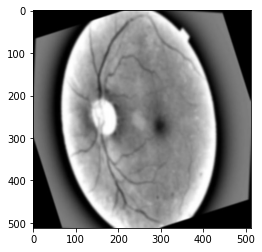

In [23]:
import glob
import random
test_img = glob.glob('/content/content/Diabetic_Balanced_Data/test/*/*.jpeg')
img_select = random.randint(1,len(test_img))

print(test_img[img_select])
img = plt.imread(test_img[img_select])
plt.imshow(img,cmap = 'gray')

In [24]:
test_data =glob.glob('/content/content/Diabetic_Balanced_Data/test/*/*.jpeg')
print("Test data ",len(test_data))
img_files = [os.path.basename(name) for name in test_data]
test_label = [name.split('/')[-2] for name in test_data]
test_df = pd.DataFrame({'filename':img_files,'label':test_label,})
test_df.to_csv('test_data.csv')
test_df

Test data  4971


,filename,label
0,42633_right._aug_30.jpeg,2
1,41021_left._aug_13.jpeg,2
2,5783_left._aug_21.jpeg,2
3,33321_right._aug_25.jpeg,2
4,8515_right.jpeg,2
...,...,...
4966,2880_right._aug_21._aug_25._aug_24.jpeg,4
4967,10193_right._aug_27.jpeg,4
4968,30549_left._aug_6._aug_8.jpeg,4
4969,15590_left.jpeg,4


In [25]:
predictions = []
for iter,row in test_df.iterrows():
  filename = join('/content/content/Diabetic_Balanced_Data/test/',join(row.label,row.filename))
  img = decode_img(filename,shape)
  pred = diab_model.predict(img)
  y_classes = np.argmax(pred)
  #print(y_classes)
  predictions.append(pred)

In [26]:
test_df['pred_label']=predictions
print(predictions[0])
test_df.head()

[[1.4166337e-03 8.8236076e-01 1.1622068e-01 1.9766267e-06 2.2229257e-08]]


,filename,label,pred_label
0,42633_right._aug_30.jpeg,2,"[[0.0014166337, 0.88236076, 0.11622068, 1.9766..."
1,41021_left._aug_13.jpeg,2,"[[0.1952096, 3.845998e-05, 0.80475134, 5.05757..."
2,5783_left._aug_21.jpeg,2,"[[0.0004954596, 0.0075453008, 0.9915856, 0.000..."
3,33321_right._aug_25.jpeg,2,"[[0.0010429122, 0.00026653433, 0.99867874, 1.3..."
4,8515_right.jpeg,2,"[[0.06415947, 0.9293213, 0.00651891, 3.022308e..."


In [27]:
y_test = test_df['label'].astype(int)
y_pred = test_df['pred_label']

In [28]:
y_pred = test_df.apply(lambda row: np.argmax(list(row['pred_label'])) , axis=1)
print(y_test)

0       2
1       2
2       2
3       2
4       2
       ..
4966    4
4967    4
4968    4
4969    4
4970    4
Name: label, Length: 4971, dtype: int64


In [29]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
print(classification_report(y_test, y_pred))
cnf_matrix = confusion_matrix(y_test,y_pred)

              precision    recall  f1-score   support

           0       0.61      0.57      0.59      1000
           1       0.62      0.68      0.65       971
           2       0.58      0.59      0.58      1000
           3       0.91      0.86      0.89      1000
           4       0.94      0.93      0.93      1000

    accuracy                           0.73      4971
   macro avg       0.73      0.73      0.73      4971
weighted avg       0.73      0.73      0.73      4971



<Figure size 432x288 with 0 Axes>

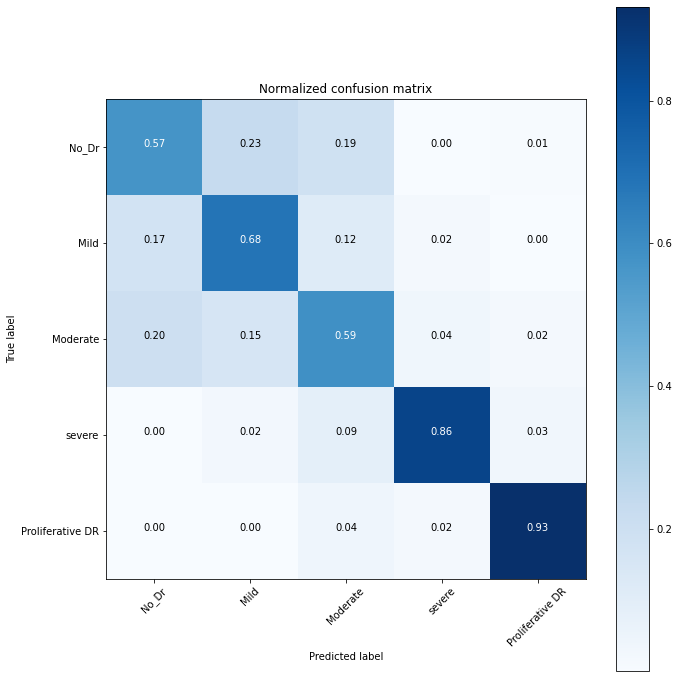

In [31]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

np.set_printoptions(precision=2)


# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes, title='Normalized confusion matrix')
plt.show()